In [0]:
!git clone -b dev https://github.com/nyikovicsmate/thesis

Cloning into 'thesis'...
remote: Enumerating objects: 137, done.
remote: Counting objects: 100% (137/137), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 1556 (delta 93), reused 105 (delta 69), pack-reused 1419
Receiving objects: 100% (1556/1556), 163.35 MiB | 29.24 MiB/s, done.
Resolving deltas: 100% (582/582), done.


In [0]:
%cd thesis

/content/thesis


In [0]:
!pip3 install -q gdown
# bsd500_gray.zip
!gdown https://drive.google.com/uc?id=1O2tduoLX1DdP3VoLkAQfuv5ssFxf8LPc
!unzip -q bsd500_gray.zip
# # bsd500_color.zip
!gdown https://drive.google.com/uc?id=1buG1ziqMjy18gnpkuQjqk81XrLsGjT7p
!unzip -q bsd500_color.zip
# # set14_color.zip
!gdown https://drive.google.com/uc?id=1OiDs7jRm3NZCY6ghjyE12G5hVS0fG4EM
!unzip -q set14_color.zip

Downloading...
From: https://drive.google.com/uc?id=1O2tduoLX1DdP3VoLkAQfuv5ssFxf8LPc
To: /content/thesis/bsd500_gray.zip
11.3MB [00:00, 98.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1buG1ziqMjy18gnpkuQjqk81XrLsGjT7p
To: /content/thesis/bsd500_color.zip
29.4MB [00:00, 93.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1OiDs7jRm3NZCY6ghjyE12G5hVS0fG4EM
To: /content/thesis/set14_color.zip
100% 831k/831k [00:00<00:00, 53.9MB/s]


In [0]:
%tensorflow_version 2.x
from src.networks.supervised.iterative_sampling_network import IterativeSamplingNetwork
from src.callbacks import *
from src.dataset import *
import numpy as np
import tensorflow as tf

In [0]:
batch_size = 50
seed = 1111
epochs = 2000
learning_rate = 1e-4

normalize = lambda x: np.asarray(x / 255.0, dtype=np.float32)
downsample = lambda x: np.array([cv2.resize(x_i, (x.shape[2]//2, x.shape[1]//2), interpolation=cv2.INTER_CUBIC) for x_i in x])

ds = HDFDataset("bsd500_70_70_color.h5").batch(batch_size).shuffle(seed).transform()
ds_hr = ds.map(normalize)
ds_lr = ds.map(downsample).map(normalize)

input_shape = (None, None, 3)
loss_func = tf.keras.losses.mse
cb = [TrainingCheckpointCallback(appendix="_color", save_freq=10),
       ExponentialDecayCallback(learning_rate, epochs/4, decay_rate=0.9)]

In [0]:
network = IterativeSamplingNetwork(input_shape=input_shape)
network.train(ds_lr, ds_hr, loss_func, epochs, learning_rate, cb)

[2020-05-19 12:44:18,556] INFO _train(): Epoch: 0 train_loss: 250219.66
[2020-05-19 12:44:30,105] INFO _train(): Epoch: 1 train_loss: 61495.09
[2020-05-19 12:44:41,697] INFO _train(): Epoch: 2 train_loss: 42387.32
[2020-05-19 12:44:53,305] INFO _train(): Epoch: 3 train_loss: 33976.80
[2020-05-19 12:45:04,963] INFO _train(): Epoch: 4 train_loss: 29714.26
[2020-05-19 12:45:16,620] INFO _train(): Epoch: 5 train_loss: 27135.86
[2020-05-19 12:45:28,265] INFO _train(): Epoch: 6 train_loss: 25385.80
[2020-05-19 12:45:39,935] INFO _train(): Epoch: 7 train_loss: 24113.42
[2020-05-19 12:45:51,591] INFO _train(): Epoch: 8 train_loss: 23130.52
[2020-05-19 12:46:03,221] INFO _train(): Epoch: 9 train_loss: 22358.71
[2020-05-19 12:46:03,222] INFO call(): Saving state after 10 epochs.
[2020-05-19 12:46:03,318] INFO save_state(): Saved state.
[2020-05-19 12:46:14,957] INFO _train(): Epoch: 10 train_loss: 21717.62
[2020-05-19 12:46:26,613] INFO _train(): Epoch: 11 train_loss: 21170.46
[2020-05-19 12:46:

[2020-05-19 19:12:19,387] INFO load_state(): Loaded state with: 
Train time: 05h:50m:02s
Epochs:     2000
Loss:       7456.5151
[2020-05-19 19:12:20,721] INFO _predict(): Predicted images with shape: (14, 70, 70, 3)
   HR   ALIASED   NETWORK   


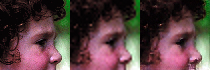

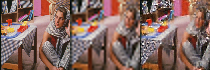

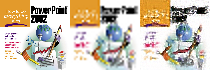

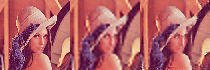

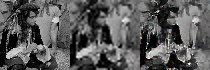

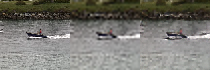

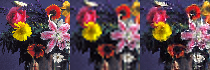

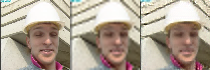

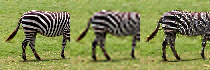

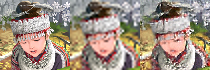

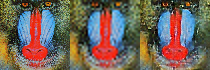

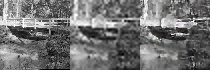

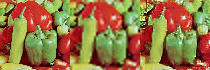

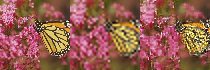

SSIM
max: [7] 0.87    min: [10] 0.54    avg: 0.65
TOTAL_VARIATION
max: [2] 3238.50    min: [0] 924.18    avg: 2284.71
PSNR
max: [0] 26.76    min: [2] 14.05    avg: 19.22
MEAN_SQUARED_ERROR
max: [2] 192.85    min: [0] 10.32    avg: 75.95
MEAN_ABSOLUTE_ERROR
max: [2] 543.45    min: [0] 152.08    avg: 372.86


In [0]:
from google.colab.patches import cv2_imshow

ds_ev_lr = DirectoryDataset("set14_70_70_color").map(downsample).map(normalize)
ds_ev_hr = DirectoryDataset("set14_70_70_color").map(normalize)

# load best network state
network.load_state("_color")

with ds_ev_lr as x, ds_ev_hr as y:
    x_batch = next(iter(x))
    y_batch = next(iter(y))
    # predict
    y_pred = network.predict(x_batch)
    print("   HR   ALIASED   NETWORK   ")
    for image_idx in range(len(x_batch)):
        aliased = tf.image.resize(x_batch[image_idx], size=tuple(y_batch[image_idx].shape[:2]), method="bicubic", antialias=True)
        img_0 = np.concatenate((y_batch[image_idx], aliased, y_pred[image_idx]), axis=1)
        cv2_imshow(img_0*255)
    # evaluate
    results = network.evaluate(y_batch, y_pred)

[2020-05-19 19:26:26,178] INFO _predict(): Predicted images with shape: (10, 70, 70, 3)
   HR   ALIASED   NETWORK   


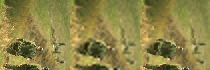

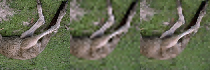

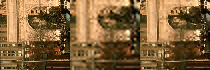

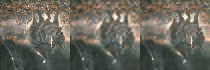

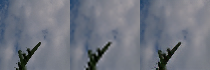

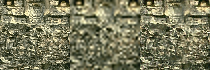

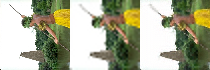

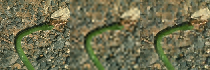

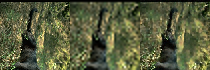

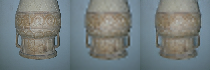

SSIM
max: [4] 0.97    min: [7] 0.68    avg: 0.80
TOTAL_VARIATION
max: [5] 4458.91    min: [4] 413.22    avg: 1606.71
PSNR
max: [4] 37.05    min: [7] 21.77    avg: 26.05
MEAN_SQUARED_ERROR
max: [7] 32.60    min: [4] 0.97    avg: 16.45
MEAN_ABSOLUTE_ERROR
max: [7] 300.18    min: [4] 36.05    avg: 189.67


In [0]:
# PREDICT WITH THE TRAINING DATASET - TRANSFORMED

ds = HDFDataset("bsd500_70_70_color.h5").batch(10).transform()
ds_hr = ds.map(normalize)
ds_lr = ds.map(downsample).map(normalize)

with ds_lr.batch(10) as x, ds_hr.batch(10) as y:
    x_batch = next(iter(x))
    y_batch = next(iter(y))
    # predict
    y_pred = network.predict(x_batch)
    print("   HR   ALIASED   NETWORK   ")
    for image_idx in range(len(x_batch)):
        aliased = tf.image.resize(x_batch[image_idx], size=tuple(y_batch[image_idx].shape[:2]), method="bicubic", antialias=True)
        img_0 = np.concatenate((y_batch[image_idx], aliased, y_pred[image_idx]), axis=1)
        cv2_imshow(img_0*255)
    # evaluate
    results = network.evaluate(y_batch, y_pred)

[2020-05-19 19:27:05,079] INFO _predict(): Predicted images with shape: (10, 70, 70, 3)
   HR   ALIASED   NETWORK   


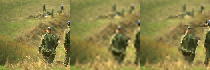

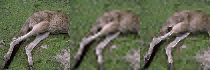

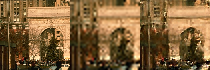

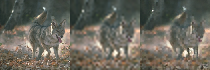

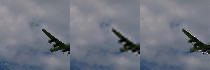

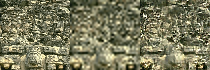

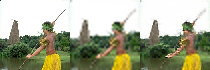

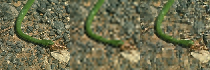

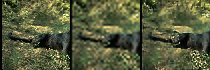

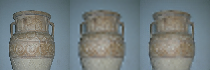

SSIM
max: [4] 0.95    min: [5] 0.45    avg: 0.68
TOTAL_VARIATION
max: [5] 4601.00    min: [4] 455.49    avg: 1665.94
PSNR
max: [4] 31.25    min: [5] 13.76    avg: 22.41
MEAN_SQUARED_ERROR
max: [5] 206.28    min: [4] 3.68    avg: 50.78
MEAN_ABSOLUTE_ERROR
max: [5] 763.79    min: [4] 49.24    avg: 295.96


In [0]:
# PREDICT WITH THE TRAINING DATASET - NON-TRANSFORMED

ds = HDFDataset("bsd500_70_70_color.h5").batch(10)
ds_hr = ds.map(normalize)
ds_lr = ds.map(downsample).map(normalize)

with ds_lr.batch(10) as x, ds_hr.batch(10) as y:
    x_batch = next(iter(x))
    y_batch = next(iter(y))
    # predict
    y_pred = network.predict(x_batch)
    print("   HR   ALIASED   NETWORK   ")
    for image_idx in range(len(x_batch)):
        aliased = tf.image.resize(x_batch[image_idx], size=tuple(y_batch[image_idx].shape[:2]), method="bicubic", antialias=True)
        img_0 = np.concatenate((y_batch[image_idx], aliased, y_pred[image_idx]), axis=1)
        cv2_imshow(img_0*255)
    # evaluate
    results = network.evaluate(y_batch, y_pred)

In [0]:
!zip -r ./iterativesamplingnetwork_color.zip ./checkpoints/iterativesamplingnetwork_color

  adding: checkpoints/iterativesamplingnetwork_color/ (stored 0%)
  adding: checkpoints/iterativesamplingnetwork_color/checkpoint (deflated 37%)
  adding: checkpoints/iterativesamplingnetwork_color/weights.data-00001-of-00002 (deflated 7%)
  adding: checkpoints/iterativesamplingnetwork_color/state.dat (deflated 14%)
  adding: checkpoints/iterativesamplingnetwork_color/weights.data-00000-of-00002 (deflated 85%)
  adding: checkpoints/iterativesamplingnetwork_color/weights.index (deflated 77%)


In [0]:
from google.colab.files import download

download("iterativesamplingnetwork_color.zip")